# Assignment #9: Tensor Networks

In this assignment we will learn how to use matrix product states (MPS) to compress fully connected layers and perform simple MPS contractions. Instead of compressing a weight matrix of fully connected layer, we will consider the compression of a large image, which can also be nicely visualized.

## Preprocess the image

First we will load the image, convert it to a grayscale, and resize it such that the height will be 4096 by keeping the aspect ratio constant. Finally, we will crop the image to size 4096x4096 and convert it to a NumPy array A.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

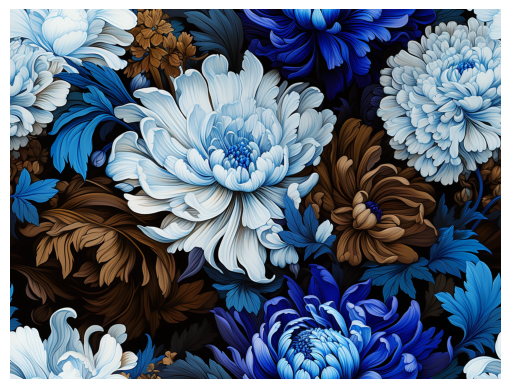

In [2]:
# Load the image
colored_image = cv2.imread('data/seamless-flowers-pattern-16952868310zL.jpg')

plt.imshow(colored_image)
plt.axis('off')
plt.show()

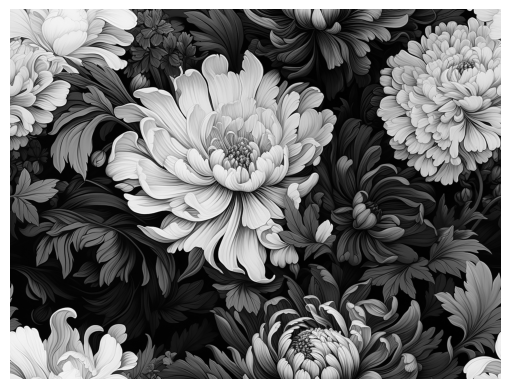

In [3]:
# Convert it to grayscale
grayscale_image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2GRAY)

plt.imshow(grayscale_image, cmap='gray')
plt.axis('off')
plt.show()

In [4]:
colored_image.shape

(1446, 1920, 3)

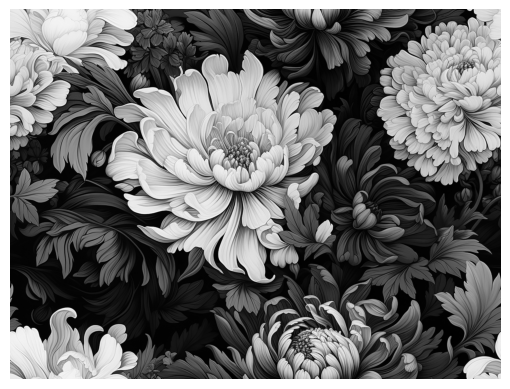

In [5]:
# Resize the image while maintaining the aspect ratio
aspect_ratio = grayscale_image.shape[1] / grayscale_image.shape[0]
target_width = int(4096 * aspect_ratio)
resized_image = cv2.resize(grayscale_image, (target_width, 4096))

plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()

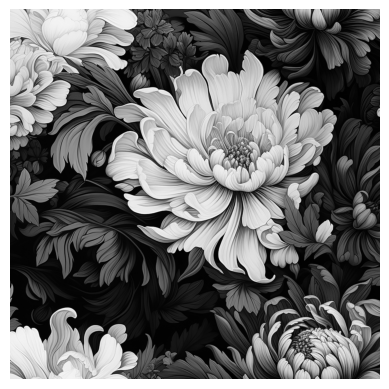

In [6]:
# Crop the image
start_row = (resized_image.shape[0] - 4096) // 2
start_col = (resized_image.shape[0] - 4096) // 2
cropped_image = resized_image[start_row:(start_row + 4096), start_col:(start_col + 4096)]

plt.imshow(cropped_image, cmap='gray')
plt.axis('off')
plt.show()

In [7]:
# Convert the image to numpy array
A = np.array(cropped_image)
A

array([[233, 233, 232, ..., 158, 156, 155],
       [233, 233, 233, ..., 158, 156, 155],
       [233, 233, 233, ..., 159, 156, 155],
       ...,
       [233, 233, 233, ..., 158, 160, 164],
       [233, 233, 233, ..., 155, 157, 161],
       [233, 233, 233, ..., 154, 157, 160]], dtype=uint8)

## Image compression method

Now we will write a method that compresses the image by transforming it to a matrix product state with fixed bond dimension D:
- Reshape the 2D array A of size 4096x4096 representing the image to a tensor of size 24, i.e. A_{a,b} -> A_{i_1,...,i_12,j_1,..., j_12}. 2^12 = 4096
- Transpose the tensor obtained in the previous step such that the indices i and j will be alternative, i.e. A_{i_1,...,i_12,j_1,...,j_12} -> A_{i_1,j_1,i_2,j_2,...,i_12,j_12}.
- Reshape the tensor obtained in the previous step by combining the even and odd indices, i.e. A_{i_1,j_1,i_2,j_2,...,i_12,j_12} -> A_{a_1,...,a_12}, where a_k = (i_k, j_k).
- Finally, compress the tensor obtained in the previous step by using successive SVD decompositions. In each decomposition step keep at most D largest singular values (Use D <= 512).


In [8]:
def convert_to_tensor(image):
  # Reshape the 4096x4096 array into tensor of size 24 * [2] (2^12, 2^12)
  tensor = np.reshape(image, [2]*24)

  # Transpose the tensor to alternate indices (even and odd) [0, 12, 1, 13, ..., 11, 23]
  reordered_indices = np.array([i for pair in zip(range(12), range(12, 24)) for i in pair])
  transposed_tensor = np.transpose(tensor, reordered_indices)

  # Reshape the tensor by combining even and odd indices
  return transposed_tensor.reshape([4]*12)

In [9]:
tensor = convert_to_tensor(A)
tensor.shape

(4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)

In [10]:
def convert_to_image(tensor):
  # Reshape the tensor by separating even and odd indices
  reshaped_tensor = np.reshape(tensor, [2] * 24)

  # Transpose tensor to its original format [0, 2, 4, ..., 22, 1, 3, 5, ..., 23]
  reordered_indices = np.array([*range(0, 24, 2)] + [*range(1, 24, 2)])
  transposed_tensor = np.transpose(reshaped_tensor, reordered_indices)

  # Reshape the tensor to its original image size (4096, 4096)
  return transposed_tensor.reshape(4096, 4096).astype('uint8')

In [11]:
image = convert_to_image(tensor)
image.shape

(4096, 4096)

In [12]:
def mps_compression(tensor, bond_dimension, show_dimensions=True):
  mps_tensors = []
  first_dimension = 1

  for i in range(tensor.ndim - 1):
    # Reshape the tensor into a matrix
    matrix = tensor.reshape(first_dimension * 4, -1)
    # Apply SVD
    U, S, V = np.linalg.svd(matrix, full_matrices=False)

    # Keep only the bond_dimension best singular values
    D = min(len(S), bond_dimension)
    U = U[:, :D]
    S = np.diag(S[:D])
    V = V[:D]

    # Calculate the new tensor
    tensor = np.dot(S, V)
    U = U.reshape(first_dimension, 4, tensor.shape[0])

    # Save the U matrix and incease the size of the first dimension of the matrix
    mps_tensors.append(U)
    first_dimension = tensor.shape[0]
    if show_dimensions:
      print(f"Shape of tensor at index {i+1}: {U.shape}")

  tensor = tensor.reshape(4, 4, 1)
  mps_tensors.append(tensor)
  if show_dimensions:
    print(f"Shape of tensor at index {12}: {tensor.shape}")

  return mps_tensors

In [13]:
mps_tensors = mps_compression(tensor, 512)

Shape of tensor at index 1: (1, 4, 4)
Shape of tensor at index 2: (4, 4, 16)
Shape of tensor at index 3: (16, 4, 64)
Shape of tensor at index 4: (64, 4, 256)
Shape of tensor at index 5: (256, 4, 512)
Shape of tensor at index 6: (512, 4, 512)
Shape of tensor at index 7: (512, 4, 512)
Shape of tensor at index 8: (512, 4, 256)
Shape of tensor at index 9: (256, 4, 64)
Shape of tensor at index 10: (64, 4, 16)
Shape of tensor at index 11: (16, 4, 4)
Shape of tensor at index 12: (4, 4, 1)


In [14]:
num_params = sum(np.prod(tensor.shape) for tensor in mps_tensors)
num_params

3285536

In [15]:
compressed_tensor = mps_tensors[0]
print(compressed_tensor.shape)
for i in range(1, 12):
  compressed_tensor = np.einsum('...i,ijk->...jk', compressed_tensor, mps_tensors[i])
  print(compressed_tensor.shape)

(1, 4, 4)
(1, 4, 4, 16)
(1, 4, 4, 4, 64)
(1, 4, 4, 4, 4, 256)
(1, 4, 4, 4, 4, 4, 512)
(1, 4, 4, 4, 4, 4, 4, 512)
(1, 4, 4, 4, 4, 4, 4, 4, 512)
(1, 4, 4, 4, 4, 4, 4, 4, 4, 256)
(1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 64)
(1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 16)
(1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4)
(1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1)


In [16]:
image = convert_to_image(compressed_tensor)
image.shape

(4096, 4096)

In [17]:
rank = int(num_params / (2**13))
U, S, V = np.linalg.svd(A, full_matrices=False)

U = U[:, :rank]
S = np.diag(S[:rank])
V = V[:rank, :]

image_svd = U @ S @ V
print(f"For MPS params {num_params} we have created SVD compression with rank {rank} and params {U.size + S.size + V.size}")

For MPS params 3285536 we have created SVD compression with rank 401 and params 3445793


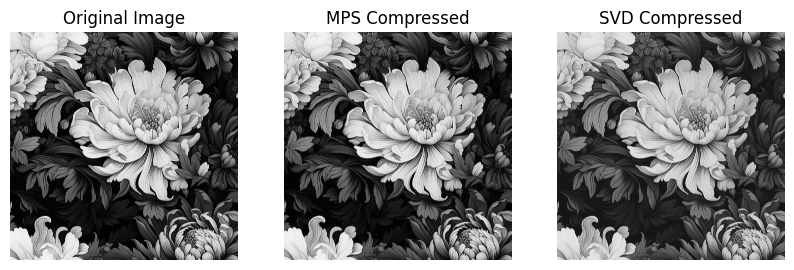

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.imshow(A, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image, cmap='gray')
plt.title('MPS Compressed')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_svd, cmap='gray')
plt.title('SVD Compressed')
plt.axis('off')

plt.show()

## Evaluation

Now let's calculate the number of parameters in the compressed MPS and visually compare the obtained MPS compressed image with simple SVD compressed image with the same number of parameters. We will also analyze the compression factor (ratio of number of params in the original matrix to the number of params in the compressed matrix) and the error (using metrics such as MSE and SSIM) of the compression as a function of the bond dimensions, namely the size of the matrices in the MPS. Compare the errors obtained with the MPS and SVD compressed images as a function of the compression factor. Why is the MPS compression better? Isn't SVD an optimal decomposition concerning the 2-norm?

In [19]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

Bond dimensions: 100%|██████████| 5/5 [04:13<00:00, 50.67s/it]


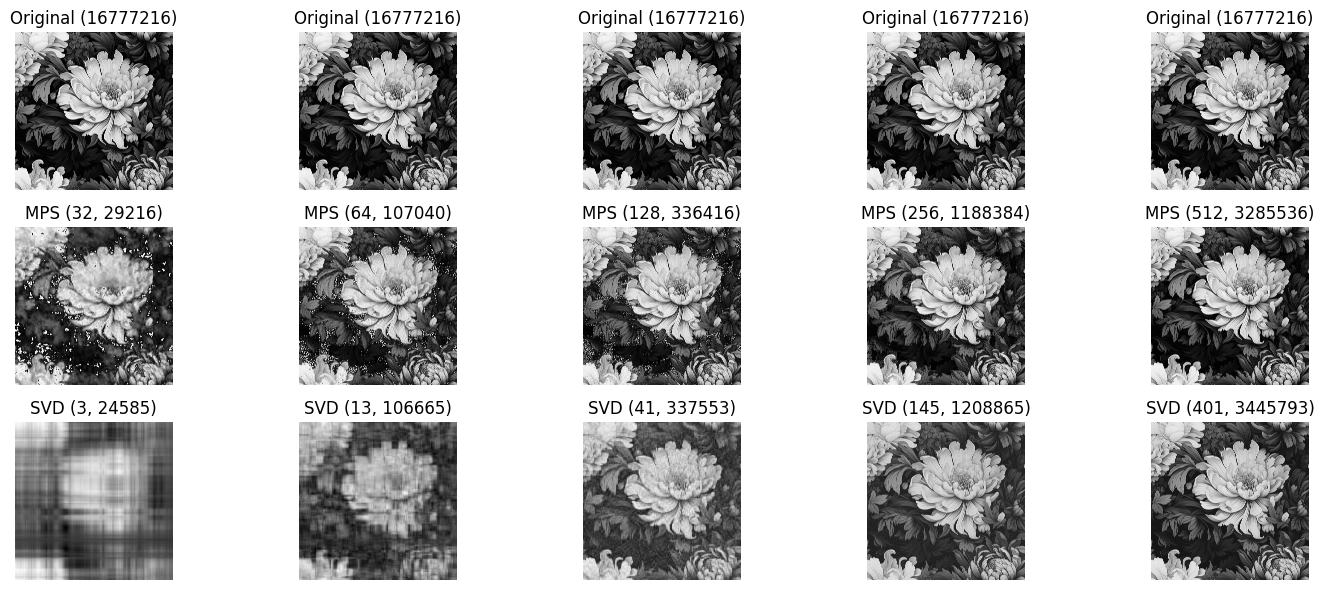

In [20]:
bond_dimensions = [32, 64, 128, 256, 512]
compression_factors_mps = []
compression_factors_svd = []
errors_mps = []
errors_svd = []
ssim_values_mps = []
ssim_values_svd = []
image_params = np.prod(A.shape)

# Convert image to tensor
tensor = convert_to_tensor(A)
# Calculate the U, S and V matrices for the whole image
U, S, V = np.linalg.svd(A, full_matrices=False)

fig, axes = plt.subplots(3, len(bond_dimensions), figsize=(15, 6))
for i, bond_dimension in tqdm(enumerate(bond_dimensions), desc="Bond dimensions", total=len(bond_dimensions)):
  # Calculate the mps compression
  mps_tensors = mps_compression(tensor, bond_dimension, show_dimensions=False)

  # Calculate the compressed image
  compressed_tensor = mps_tensors[0]
  for j in range(1, 12):
    compressed_tensor = np.einsum('...i,ijk->...jk', compressed_tensor, mps_tensors[j])
  image_mps = convert_to_image(compressed_tensor)

  # Calculate the normal SVD compression for the same parameters
  mps_params = sum(np.prod(tensor.shape) for tensor in mps_tensors)
  rank = int(mps_params / (2**13))

  U_ranked = U[:, :rank]
  S_ranked = np.diag(S[:rank])
  V_ranked = V[:rank, :]
  image_svd = U_ranked @ S_ranked @ V_ranked
  svd_params = U_ranked.size + S_ranked.size + V_ranked.size

  # Calculate compression factors, errors and similarities
  compression_factor_mps = image_params / mps_params
  compression_factor_svd = image_params / svd_params
  error_mps = mean_squared_error(A, image_mps)
  error_svd = mean_squared_error(A, image_svd)
  ssim_mps = ssim(A, image_mps, data_range=image_mps.max() - image_mps.min())
  ssim_svd = ssim(A, image_svd, data_range=image_svd.max() - image_svd.min())

  compression_factors_mps.append(compression_factor_mps)
  compression_factors_svd.append(compression_factor_svd)
  errors_mps.append(error_mps)
  errors_svd.append(error_svd)
  ssim_values_mps.append(ssim_mps)
  ssim_values_svd.append(ssim_svd)

  # Plot the images
  axes[0, i].imshow(A, cmap='gray')
  axes[0, i].set_title(f'Original ({image_params})')
  axes[0, i].axis('off')

  axes[1, i].imshow(image_mps, cmap='gray')
  axes[1, i].set_title(f'MPS ({bond_dimension}, {mps_params})')
  axes[1, i].axis('off')

  axes[2, i].imshow(image_svd, cmap='gray')
  axes[2, i].set_title(f'SVD ({rank}, {svd_params})')
  axes[2, i].axis('off')

plt.tight_layout()
plt.show()

From the visualization we can see that MPS seems to make visually better compressions than just applying SVD on the original image. Using smaller parameters than 330000 seems to give us pretty blurry image using SVD, while for the MPG there are some pixel problems, but it is visible what we have on the image. Using more parameters seem to give us better compression for the SVD, but the MPS compressed image still seems to have better quality.

We can also see that even using the biggest bond dimension (512) seem to compress the parameters pretty much and the quality of the image remains almost unchanged. In this case, when we have the most parameters for the compression, we seem to have 5 times less parameters than we do in the original image by keeping the quality. Using the same amount parameters for SVD compression also gives us good result, but the quality seems to be worse than MPS. By decreasing the parameters, the quality of the SVD seems to be getting worse much faster than the quality of the MPS compression.

Let's also plot the compression factors, errors and SSIM values to be able to analyze the quality of both compression methods better.

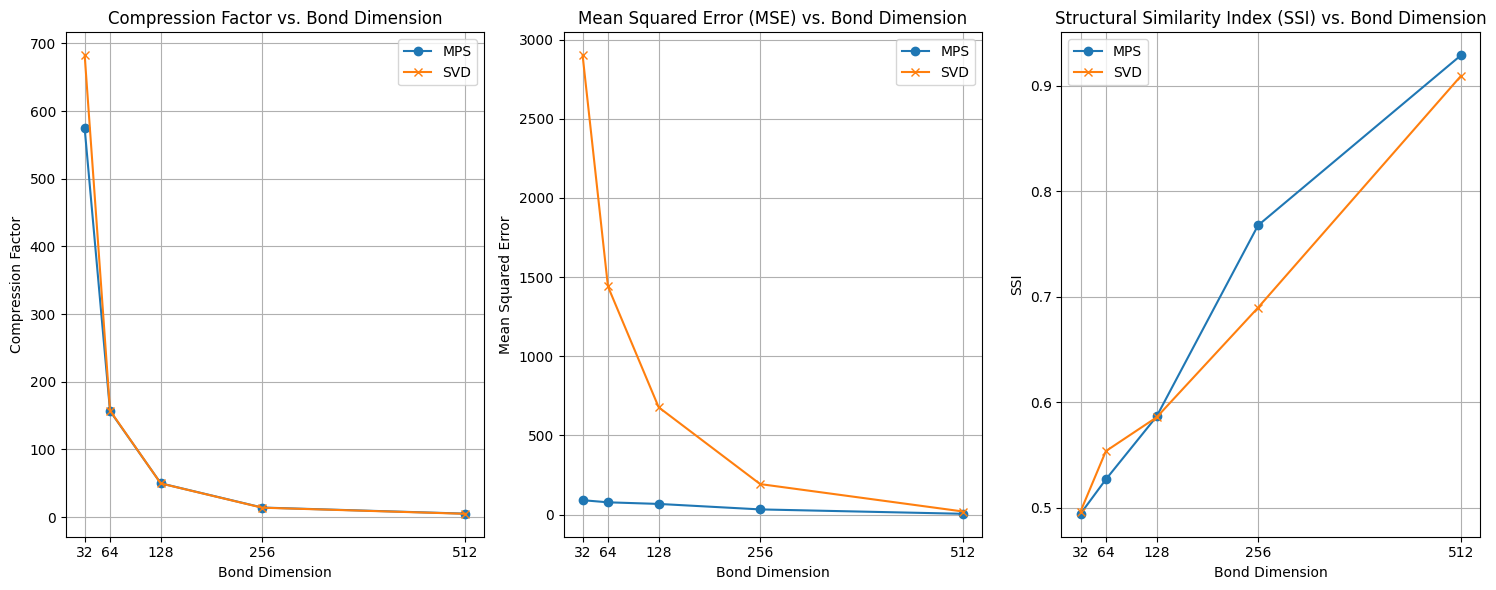

In [22]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.plot(bond_dimensions, compression_factors_mps, 'o-', label='MPS')
plt.plot(bond_dimensions, compression_factors_svd, 'x-', label='SVD')
plt.title('Compression Factor vs. Bond Dimension')
plt.xlabel('Bond Dimension')
plt.ylabel('Compression Factor')
plt.xticks(bond_dimensions)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(bond_dimensions, errors_mps, 'o-', label='MPS')
plt.plot(bond_dimensions, errors_svd, 'x-', label='SVD')
plt.title('Mean Squared Error (MSE) vs. Bond Dimension')
plt.xlabel('Bond Dimension')
plt.ylabel('Mean Squared Error')
plt.xticks(bond_dimensions)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(bond_dimensions, ssim_values_mps, 'o-', label='MPS')
plt.plot(bond_dimensions, ssim_values_svd, 'x-', label='SVD')
plt.title('Structural Similarity Index (SSI) vs. Bond Dimension')
plt.xlabel('Bond Dimension')
plt.ylabel('SSI')
plt.xticks(bond_dimensions)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The first plot shows us how much the data has been compressed compared to its original size using both compression method. We can see that the only difference here is when we are using pretty low bond dimension (32) and therefore small amount of parameters. In this case the SVD compression seems to have more effective compression, eventhough we see that the resulted image has worse qaulity than the one from the MPS compression. For the other bond dimension values (number of parameters), we can see that both methods have similarly effective compressions.

The second plot captures the average squared difference between the original image and the compressed image using both methods. Here we can see that the MPS compression seem to have better approximation for each bond dimension value (number of parameters). As we can see also on the visualized images, it seems that for the lower bond dimension, there is bigger difference between the error of the approximation done with MPS and SVD. By increasing the bond dimension (number of parameters), these values are getting closer and closer until for the maximum value they are almost the same.

While MSE provides a straightforward measure of overall pixel-wise differences, the Structural Similarity Index metric offers a relevant evaluation of images by considering structural information. On the last plot we can see the similarity in structure between the original image and the compressed image using both compression methods. This tell us how well the compressed representation preserves the structural information present in the original image. We can see that for all bond dimensions for both methods all values are above 0 (even above 0.4), which tell us that there is visible similarity. As expected the similarity grows for both methods with increasing of the bond dimension and therefore the number of parameters. Eventhough on the visualization it seems that the MPS is better in each case, we can see that for the first 2 values of bond dimension, the SVD seems to preserves better the structural information present in the original image. Anyway, all other values and therefore in general the MPS compression still seems to make better approximation of the original image by using a lot less parameters.